In [7]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from random import seed, shuffle
import os

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
sns.set_theme(style="white")

from sklearn.decomposition import PCA
import pacmap
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.cluster import KMeans, SpectralClustering

from scipy import stats
from scipy.spatial.distance import directed_hausdorff, euclidean, cosine, pdist
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics.cluster import adjusted_rand_score

from src.downsample import downsamp_audio
import src.dimension_reducer as dr
import src.distance_metrics as dm
import src.emb_manipulator as em

from IPython.display import clear_output

import warnings
warnings.filterwarnings('ignore')

#Directory where already-generated embeddings stored
embedding_dir = '/Users/rahulbrito/Documents/projects/infantvoice/data/embeddings'

file = '03016_diarized_pyv2.csv'
emb = pd.read_csv(os.path.join(embedding_dir,file), index_col=0)
emb_down_unscaled = em.resample_data(emb,1)

#average emebdding for each participant
emb_a = em.embedding_averager(emb_down_unscaled)

#egemap (88 features) for each participant
gemap_file = '040122_segmented_postpartum_moms_gemaps_2sec.csv'
gemap_unscaled = pd.read_csv(os.path.join(embedding_dir,gemap_file), index_col=0)
gemap_unscaled = gemap_unscaled.drop(columns=['start','end'])


scaler = StandardScaler()
emb_down = pd.DataFrame(scaler.fit_transform(emb_down_unscaled.drop(columns='part_id')))
emb_down['part_id'] = emb_down_unscaled.part_id.to_numpy()

gemap = pd.DataFrame(scaler.fit_transform(gemap_unscaled.drop(columns='part_id')))
gemap['part_id'] = gemap_unscaled.part_id.to_numpy()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
#default
#learning_rate = emb_down.shape[0]//12
#perplexity = 30

#max global structure
perplexity = 135
learning_rate = 200

#default
#n_neighbors = 10
#dist=0.1

#max global structure
n_neighbors=14
dist=10E-3


In [5]:
###Run dimension reduction with different methods on the embeddings to establish a baseline before leaving any participants out
#Using tsne with perplexity=30 (default) since N/100<30, and learning rate of n/12. Random seed is 42 so the result is the same each time
emb_tsne = dr.run_tsne(emb_down, perplexity = perplexity, init='pca', learning_rate=learning_rate)

#run umap with default parameters
emb_umap = dr.run_umap(emb_down, n_neighbors=n_neighbors, dist=dist)


labels = emb_down.part_id

#PACMAP for comparison
emb_pacmap = dr.run_pacmap(emb_down)


#PCA for comparison
pca = PCA(n_components=512)
#exp_var = pca.fit(emb_down.drop(columns='part_id')).explained_variance_ratio_
emb_pca = pd.DataFrame(pca.fit_transform(emb_down.drop(columns='part_id')))
emb_pca = emb_pca.iloc[:,:2]
emb_pca.columns = ['dim0', 'dim1']

[Text(0.5, 1.0, '     micro   meso  macro\npca  0.271  0.488  0.419')]

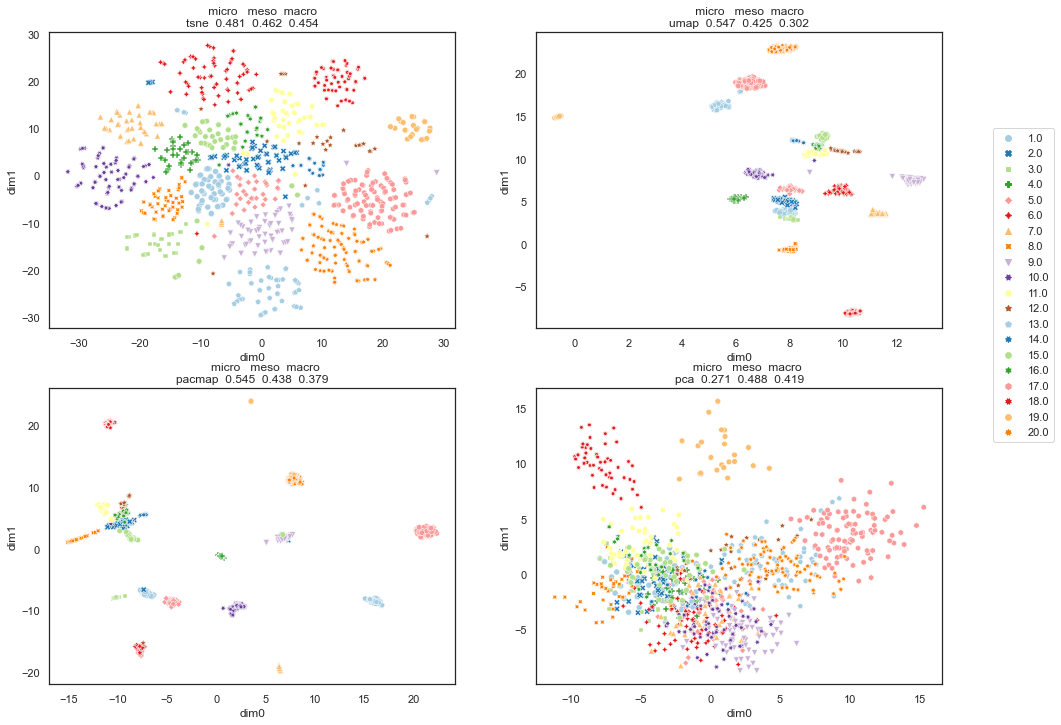

In [6]:
#measure 'knn', 'knc', 'cpd' to determine how well micro, meso, and marco structure of high-D preserved by dim reduction, per Kobak&Berens2019
knn=50
knn_classes=4
subsetsize=700

#we are always comparing to emb_down as our high-dimension embedding. 
high_dim = emb_down.drop(columns='part_id').to_numpy()
classes= emb_down.part_id.to_numpy() #extract the categories/labels

#compare tsne to embeddings
low_dim = emb_tsne.drop(columns='part_id').to_numpy()
dist_tsne = dm.embedding_quality(high_dim, low_dim, classes, knn=knn, knn_classes=knn_classes, subsetsize=subsetsize)

#compare umap to embeddings
low_dim = emb_umap.drop(columns='part_id').to_numpy()
dist_umap = dm.embedding_quality(high_dim, low_dim, classes, knn=knn, knn_classes=knn_classes, subsetsize=subsetsize)

#comapre pacmap to embeddings
low_dim = emb_pacmap.to_numpy()
dist_pacmap = dm.embedding_quality(high_dim, low_dim, classes,  knn=knn,  knn_classes=knn_classes, subsetsize=subsetsize)

#compare pca to embeddings
low_dim = emb_pca.to_numpy()
dist_pca = dm.embedding_quality(high_dim, low_dim, classes,  knn=knn,  knn_classes=knn_classes, subsetsize=subsetsize)

#create a dataframe of all distance metrics for each dimension method
dist = pd.DataFrame(np.vstack((dist_tsne, dist_umap,dist_pacmap,dist_pca)), columns = ['micro', 'meso', 'macro'], index = ['tsne', 'umap', 'pacmap','pca'])
dist = dist.round(decimals=3)

##plot 2 dimensions from each dimension reduction
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(16,12))

clust_plt_tsne = sns.scatterplot(x=emb_tsne.dim0, y=emb_tsne.dim1, ax=ax1, palette="Paired", hue=emb_tsne.part_id, style=emb_tsne.part_id, legend=False)
#ax1.legend(loc="lower center",bbox_to_anchor=(1.3,1), ncol=2)
clust_plt_tsne.set(title = str(dist[dist.index=='tsne']))

clust_plt_umap = sns.scatterplot(x=emb_umap.dim0, y=emb_umap.dim1, ax=ax2, palette="Paired", hue=emb_umap.part_id, style=emb_tsne.part_id)
ax2.legend(loc="lower center",bbox_to_anchor=(1.2, -0.4), ncol=1)
clust_plt_umap.set(title = str(dist[dist.index=='umap']))

clust_plt_pacmap = sns.scatterplot(x=emb_pacmap.dim0, y= emb_pacmap.dim1, ax=ax3, palette="Paired", hue = labels, style=emb_tsne.part_id, legend=False)
#ax3.legend(loc="lower center",bbox_to_anchor=(1.3, 0.4), ncol=2)
clust_plt_pacmap.set(title = str(dist[dist.index=='pacmap']))

clust_plt_pca = sns.scatterplot(x=emb_pca.dim0, y= emb_pca.dim1, ax=ax4, palette="Paired", hue = labels, style=emb_tsne.part_id, legend=False)
#ax4.legend(loc="lower center",bbox_to_anchor=(1.3, 0.4), ncol=2)
clust_plt_pca.set(title = str(dist[dist.index=='pca']))

In [20]:
sil_score_tsne = metrics.silhouette_score(emb_tsne.drop(columns='part_id'), emb_tsne.part_id, metric='euclidean')
sil_score_umap = metrics.silhouette_score(emb_umap.drop(columns='part_id'), emb_umap.part_id, metric='euclidean')
sil_score_pacmap = metrics.silhouette_score(emb_pacmap.drop(columns='part_id'), emb_pacmap.part_id, metric='euclidean')
sil_score_pca = metrics.silhouette_score(emb_pca, emb_tsne.part_id, metric='euclidean')


sil_score_tsne, sil_score_umap, sil_score_pacmap, sil_score_pca
#adjusted_rand_score(emb_down_kmeans.part_id, emb_down_kmeans.kmeans_predict)

(0.2828249, 0.7655697, 0.8089583, 0.020460242)

In [4]:
## Same script but on gemaps embeddings
ge_tsne = dr.run_tsne(gemap,perplexity = perplexity, init='pca', learning_rate=learning_rate)
ge_umap = dr.run_umap(gemap, n_neighbors=n_neighbor, dist=dist)
ge_pacmap = dr.run_pacmap(gemap)

#PCA for comparison
pca_gemap = PCA(n_components=88)
#exp_var = pca.fit(emb_down.drop(columns='part_id')).explained_variance_ratio_
ge_pca = pd.DataFrame(pca_gemap.fit_transform(gemap.drop(columns='part_id')))
ge_pca = ge_pca.iloc[:,:2]
ge_pca.columns = ['dim0', 'dim1']
ge_pca['part_id'] = gemap.part_id.to_numpy()

#we are always comparing to emb_down as our high-dimension embedding. 
high_dim_gemap = gemap.drop(columns='part_id').to_numpy()
classes_gemap= gemap.part_id.to_numpy() #extract the categories/labels

#compare tsne to embeddings
low_dim_gemap = ge_tsne.drop(columns='part_id').to_numpy()
dist_tsne_gemap = dm.embedding_quality(high_dim_gemap, low_dim_gemap, classes_gemap, knn=knn,  knn_classes=knn_classes, subsetsize=subsetsize)

#compare tsne to embeddings
low_dim_gemap = ge_umap.drop(columns='part_id').to_numpy()
dist_umap_gemap = dm.embedding_quality(high_dim_gemap, low_dim_gemap, classes_gemap, knn=knn,  knn_classes=knn_classes, subsetsize=subsetsize)

#compare pacmap to embeddings
low_dim_gemap = ge_pacmap.drop(columns='part_id').to_numpy()
dist_pacmap_gemap = dm.embedding_quality(high_dim_gemap, low_dim_gemap, classes_gemap, knn=knn,  knn_classes=knn_classes, subsetsize=subsetsize)

#compare pca to embeddings
low_dim_pca = ge_pca.drop(columns='part_id').to_numpy()
dist_pca_gemap = dm.embedding_quality(high_dim_gemap, low_dim_gemap, classes_gemap, knn=knn, knn_classes=knn_classes, subsetsize=subsetsize)

dist_gemap = pd.DataFrame(np.vstack((dist_tsne_gemap, dist_umap_gemap,dist_pacmap_gemap, dist_pca_gemap)), columns = ['micro', 'meso', 'macro'], index = ['tsne', 'umap', 'pacmap', 'pca'])
dist_gemap = dist_gemap.round(decimals=3)

##plot 2 dimensions from each dimension reduction
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(16,12))

clust_plt_ge_tsne = sns.scatterplot(x=ge_tsne.dim0, y=ge_tsne.dim1, 
                                 ax=ax1, palette="Paired", hue=ge_tsne.part_id, style=ge_tsne.part_id, legend=False)
clust_plt_ge_tsne.set(title = str(dist_gemap[dist_gemap.index=='tsne']))
#ax1.legend(loc="lower center",bbox_to_anchor=(1.3,1), ncol=2)
#clust_plt_tsne.set(title = str(dist[dist.index=='tsne']))

clust_plt_ge_umap = sns.scatterplot(x=ge_umap.dim0, y=ge_umap.dim1, 
                                 ax=ax2, palette="Paired", hue=ge_umap.part_id, style=ge_umap.part_id)
ax2.legend(loc="lower center",bbox_to_anchor=(1.2, 0), ncol=1)
clust_plt_ge_umap.set(title = str(dist_gemap[dist_gemap.index=='umap']))
#clust_plt_umap.set(title = str(dist[dist.index=='umap']))

clust_plt_ge_pacmap = sns.scatterplot(x=ge_pacmap.dim0, y=ge_pacmap.dim1, 
                                ax=ax3, palette="Paired", hue=ge_pacmap.part_id, style=ge_pacmap.part_id, legend=False)
clust_plt_ge_pacmap.set(title = str(dist_gemap[dist_gemap.index=='pacmap']))

clust_plt_ge_pca = sns.scatterplot(x=ge_pca.dim0, y=ge_pca.dim1, 
                                ax=ax4, palette="Paired", hue=ge_pca.part_id, style=ge_pca.part_id, legend=False)
clust_plt_ge_pca.set(title = str(dist_gemap[dist_gemap.index=='pca']))


NameError: name 'n_neighbor' is not defined

In [59]:
#calculate hausdorff distances
haus_tsne = dm.hausdorff_distances(emb_tsne)
haus_umap = dm.hausdorff_distances(emb_umap)

haus_tsne_gemap = dm.hausdorff_distances(ge_tsne)
haus_umap_gemap = dm.hausdorff_distances(ge_umap)

Processing row 19, col 19


In [67]:
df_1 = pd.DataFrame(haus_tsne.to_numpy().flatten(), columns=['pyannote_hausdorff_tsne']).dropna()
df_2 = pd.DataFrame(haus_tsne_gemap.to_numpy().flatten(), columns=['gemaps_hausdorff_tsne']).dropna()

df_1.corrwith(df_2)

gemaps_hausdorff_tsne     NaN
pyannote_hausdorff_tsne   NaN
dtype: float64

<AxesSubplot:xlabel='pyannote_hausdorff_tsne', ylabel='gemaps_hausdorff_tsne'>

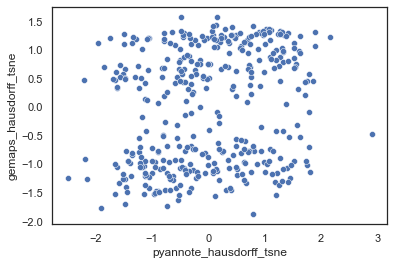

In [70]:
sns.scatterplot(x=df_1.pyannote_hausdorff_tsne, y=df_2.gemaps_hausdorff_tsne) 

In [73]:
df_1 = pd.DataFrame(haus_umap.to_numpy().flatten(), columns=['pyannote_hausdorff_umap']).dropna()
df_2 = pd.DataFrame(haus_umap_gemap.to_numpy().flatten(), columns=['gemaps_hausdorff_umap']).dropna()

df_1.corrwith(df_2)

gemaps_hausdorff_umap     NaN
pyannote_hausdorff_umap   NaN
dtype: float64

<AxesSubplot:xlabel='pyannote_hausdorff_umap', ylabel='gemaps_hausdorff_umap'>

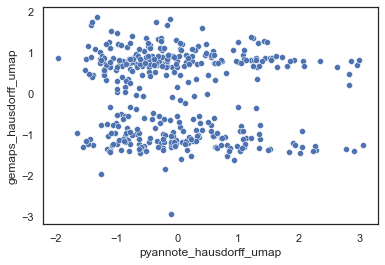

In [74]:
sns.scatterplot(x=df_1.pyannote_hausdorff_umap, y=df_2.gemaps_hausdorff_umap) 

[Text(0.5, 1.0, '     micro   meso  macro\npca  0.491  0.688  0.437')]

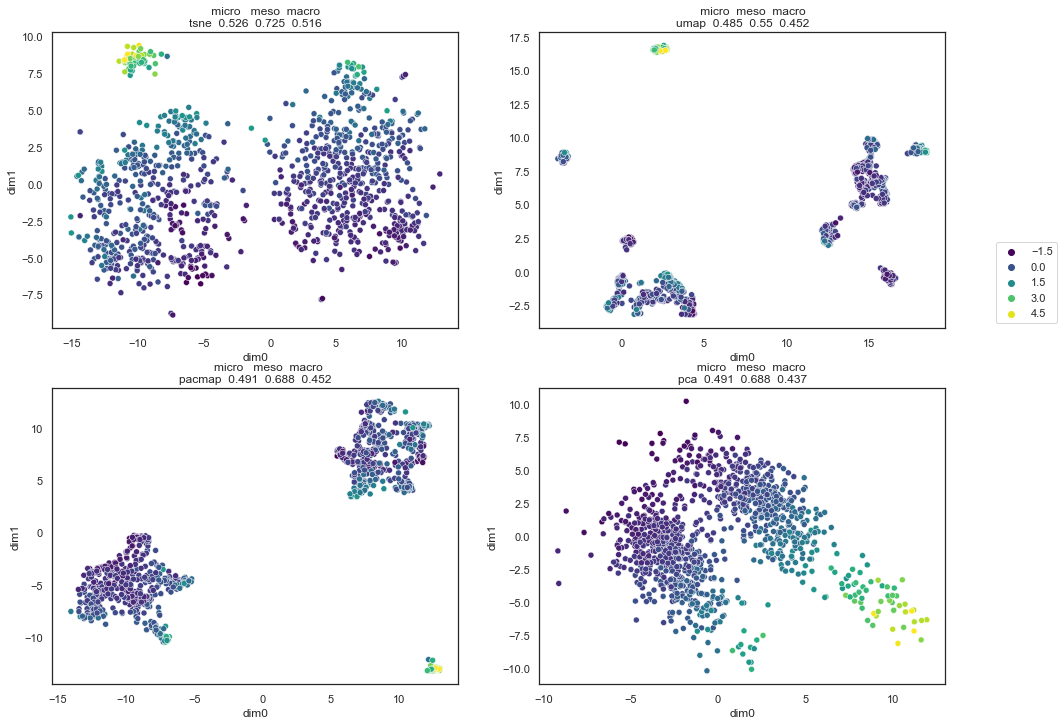

In [75]:
pal = "viridis"
hue = gemap.loc[:,13]

##plot 2 dimensions from each dimension reduction
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(16,12))

clust_plt_ge_tsne = sns.scatterplot(x=ge_tsne.dim0, y=ge_tsne.dim1, 
                                 ax=ax1, palette=pal, hue=hue, legend=False)
clust_plt_ge_tsne.set(title = str(dist_gemap[dist_gemap.index=='tsne']))
#ax1.legend(loc="lower center",bbox_to_anchor=(1.3,1), ncol=2)
#clust_plt_tsne.set(title = str(dist[dist.index=='tsne']))

clust_plt_ge_umap = sns.scatterplot(x=ge_umap.dim0, y=ge_umap.dim1, 
                                 ax=ax2, palette=pal, hue=hue)
ax2.legend(loc="lower center",bbox_to_anchor=(1.2, 0), ncol=1)
clust_plt_ge_umap.set(title = str(dist_gemap[dist_gemap.index=='umap']))
#clust_plt_umap.set(title = str(dist[dist.index=='umap']))

clust_plt_ge_pacmap = sns.scatterplot(x=ge_pacmap.dim0, y=ge_pacmap.dim1, 
                                ax=ax3, palette=pal, hue=hue, legend=False)
clust_plt_ge_pacmap.set(title = str(dist_gemap[dist_gemap.index=='pacmap']))

clust_plt_ge_pca = sns.scatterplot(x=ge_pca.dim0, y=ge_pca.dim1, 
                                ax=ax4, palette=pal, hue=hue, legend=False)
clust_plt_ge_pca.set(title = str(dist_gemap[dist_gemap.index=='pca']))

In [47]:
gemap_unscaled.columns

Index(['F0semitoneFrom27.5Hz_sma3nz_amean',
       'F0semitoneFrom27.5Hz_sma3nz_stddevNorm',
       'F0semitoneFrom27.5Hz_sma3nz_percentile20.0',
       'F0semitoneFrom27.5Hz_sma3nz_percentile50.0',
       'F0semitoneFrom27.5Hz_sma3nz_percentile80.0',
       'F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2',
       'F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope',
       'F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope',
       'F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope',
       'F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope', 'loudness_sma3_amean',
       'loudness_sma3_stddevNorm', 'loudness_sma3_percentile20.0',
       'loudness_sma3_percentile50.0', 'loudness_sma3_percentile80.0',
       'loudness_sma3_pctlrange0-2', 'loudness_sma3_meanRisingSlope',
       'loudness_sma3_stddevRisingSlope', 'loudness_sma3_meanFallingSlope',
       'loudness_sma3_stddevFallingSlope', 'spectralFlux_sma3_amean',
       'spectralFlux_sma3_stddevNorm', 'mfcc1_sma3_amean',
       'mfcc1_sma3_stddevNorm', 'mfcc2_

<AxesSubplot:>

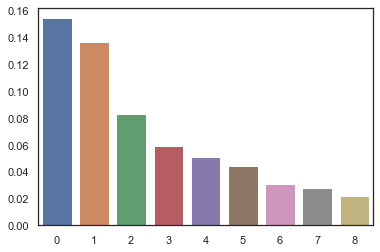

In [19]:
exp_var_gemap = pca_gemap.fit(gemap.drop(columns='part_id')).explained_variance_ratio_
sns.barplot(x=np.arange(9), y=exp_var_gemap[0:9])

[Text(0.5, 1.0, 'pc2 weights')]

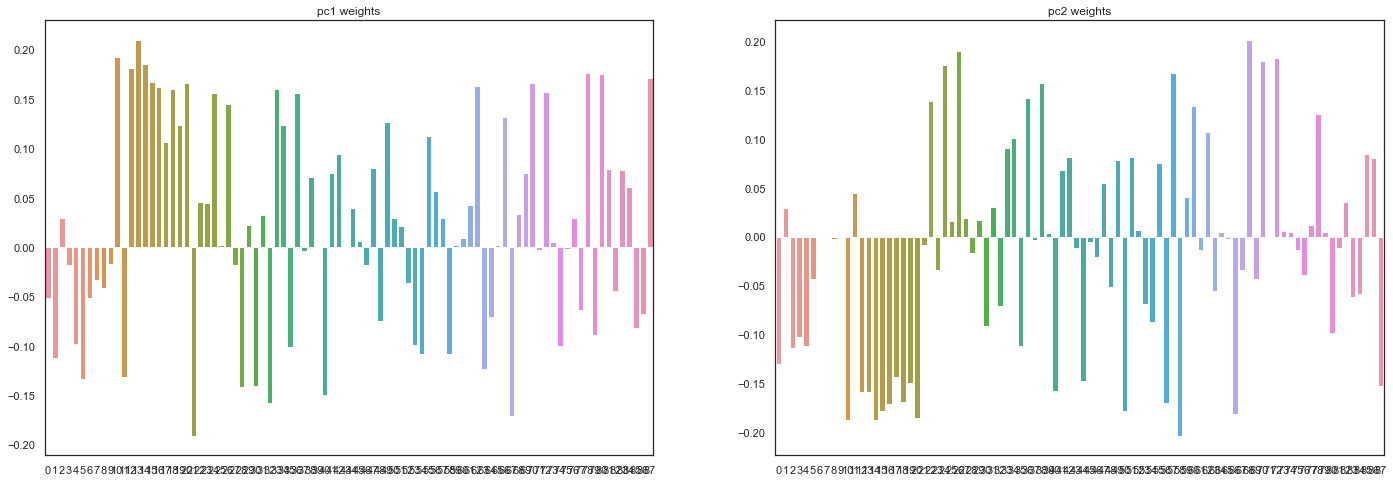

In [20]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize=(24,8))

pc1 = sns.barplot(x=np.arange(88), y = pca_gemap.components_[0,:], ax=ax1)
pc1.set(title='pc1 weights')

pc2 = sns.barplot(x=np.arange(88), y = pca_gemap.components_[1,:], ax=ax2)
pc2.set(title='pc2 weights')



In [24]:
pc1_weights = pd.Series(pca_gemap.components_[0,:])
pc1_weights.abs().nlargest(10).index

Int64Index([13, 10, 21, 14, 12, 78, 80, 87, 67, 15], dtype='int64')

In [27]:
gemap_unscaled.columns[pc1_weights.abs().nlargest(10).index]

Index(['loudness_sma3_percentile50.0', 'loudness_sma3_amean',
       'spectralFlux_sma3_stddevNorm', 'loudness_sma3_percentile80.0',
       'loudness_sma3_percentile20.0', 'slopeUV0-500_sma3nz_amean',
       'spectralFluxUV_sma3nz_amean', 'equivalentSoundLevel_dBp',
       'spectralFluxV_sma3nz_stddevNorm', 'loudness_sma3_pctlrange0-2'],
      dtype='object')

In [8]:

#cca_data_size_diff = gemap.shape[0] - emb_down.shape[0]
#emb_per_part = emb_down.groupby('part_id').count().iloc[:,0].to_numpy()
#emb_per_part = emb_per_part
gemap_part_count = gemap.groupby('part_id').count().iloc[:,0].to_numpy()
emb_part_count = emb_down.groupby('part_id').count().iloc[:,0].to_numpy()
index_len = np.minimum(gemap_part_count,emb_part_count)
samples_per_group_dict = dict(zip(gemap.groupby('part_id').count().index,index_len))

In [13]:
gemap_reduced_samples = gemap.groupby('part_id').apply(lambda group: group.sample(samples_per_group_dict[group.name])).reset_index(drop = True)
emb_down_reduced_samples = emb_down.groupby('part_id').apply(lambda group: group.sample(samples_per_group_dict[group.name])).reset_index(drop = True)

X_classes = gemap_reduced_samples.part_id #should equal Y_classes = Y.part_id

X = gemap_reduced_samples.drop(columns='part_id')
Y = emb_down_reduced_samples.drop(columns='part_id')

X_mc = X
Y_mc = Y

In [15]:
import rcca
nComponents = 88
cca = rcca.CCA(kernelcca = False, reg = 0., numCC = nComponents,)

# train on data
cca.train([X, Y])

Training CCA, kernel = None, regularization = 0.0000, 88 components


In [20]:
from sklearn.cross_decomposition import CCA

ca = CCA(n_components=88).fit(X_mc, Y_mc)
#X_c, Y_c = ca.transform(X_mc, Y_mc)

In [22]:
pd.DataFrame(ca.coef_)

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,-0.530667,2.522029e+00,1.820347,-3.437470e-01,-1.512947e+00,8.462719e-01,0.972274,-1.213606e+00,3.198328,1.566765e+00,...,-5.855199e-01,0.245461,-0.876906,0.258241,0.548976,-1.528294e+00,0.938793,3.309874e+00,-1.275447,-2.087319e+00
1,-0.055257,-5.245785e-01,-0.005480,3.204565e-01,5.337637e-02,-4.625496e-01,-0.436774,8.771135e-01,-0.929203,-7.054756e-01,...,-1.961311e-01,-0.370818,0.310369,-0.397931,0.430330,4.068512e-02,-0.092566,1.113265e-01,0.426649,2.217695e-01
2,7948.415908,7.305608e+05,-545436.491712,-9.905055e+05,-6.351544e+05,6.294155e+05,381328.709982,-9.524628e+05,401145.962186,-6.942234e+05,...,1.528058e+06,113325.395484,484428.347158,267877.514901,-523805.993994,6.755383e+05,-452789.742837,-6.225387e+05,-12414.724332,-8.084948e+05
3,0.275725,-1.261388e+00,-1.622272,5.261472e-01,-6.028620e-02,-1.394893e-01,-0.156091,3.942302e-01,-0.340833,-1.424653e+00,...,-4.923272e-01,-0.113310,-0.235656,-0.672864,-0.061824,2.822019e-01,-0.222406,-4.910930e-01,0.277980,1.767302e-02
4,-13139.643195,-1.207798e+06,901741.945908,1.637551e+06,1.050070e+06,-1.040579e+06,-630433.245016,1.574658e+06,-663194.586012,1.147723e+06,...,-2.526259e+06,-187354.634906,-800878.726602,-442866.172000,865981.072580,-1.116832e+06,748572.556014,1.029206e+06,20527.380653,1.336646e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,-0.274327,2.813340e-01,-0.260120,6.145793e-01,-5.114535e-01,-3.402602e-02,0.909259,1.199389e+00,-0.089067,-4.857380e-01,...,-6.303065e-01,-0.808206,-0.417103,0.634519,-1.368102,1.057523e+00,-0.439705,3.400986e-02,1.114011,-3.176756e-01
84,-0.154916,8.207807e-01,-0.153958,2.060322e-01,6.652115e-02,-5.208481e-01,0.111517,-8.004060e-01,-0.117342,-1.182964e-01,...,4.796952e-01,0.425212,0.186148,0.127338,0.478077,1.300695e-01,0.199714,-2.845432e-04,-0.541164,-7.693857e-01
85,-0.211544,1.183442e+00,-0.299447,6.507661e-01,2.713111e-01,-1.146693e+00,0.514149,-6.958454e-01,0.645209,2.986273e-03,...,-3.300065e-01,0.872135,-0.413342,-0.160717,0.612682,-8.502931e-01,-0.101545,8.943650e-01,0.503975,-1.010226e+00
86,0.140363,-5.768581e-01,-0.002823,-1.165581e-01,-2.115720e-01,6.015030e-01,0.205954,6.213256e-01,-0.128024,-9.919379e-01,...,1.687158e-02,-0.597203,0.111853,0.237503,-0.805274,-1.084919e-01,0.048591,-4.608840e-01,0.000524,7.423897e-01


In [32]:
cc_res = pd.DataFrame({"CCX_1":X_c[:, 0],
                       "CCY_1":Y_c[:, 0],
                       "CCX_2":X_c[:, 1],
                       "CCY_2":Y_c[:, 1],
                       "part_id":X_classes.to_numpy(),
                      })
cc_res

,CCX_1,CCY_1,CCX_2,CCY_2,part_id
0,0.255106,0.000003,0.112468,1.009182e-06,1.0
1,0.174827,0.000003,0.025387,1.075213e-06,1.0
2,0.163932,0.000003,0.112505,1.511870e-06,1.0
3,0.230277,0.000003,0.135678,2.370288e-06,1.0
4,0.174710,0.000002,0.040941,5.697120e-07,1.0
...,...,...,...,...,...
813,-0.221162,-0.000003,-0.178520,-1.832988e-06,20.0
814,-0.273900,-0.000003,-0.128401,-2.191866e-06,20.0
815,-0.247839,-0.000003,-0.116370,-2.024051e-06,20.0
816,-0.226063,-0.000003,-0.054974,-1.257857e-06,20.0


In [33]:
np.corrcoef(X_c[:, 0], Y_c[:, 0])

array([[1.        , 0.98917426],
       [0.98917426, 1.        ]])

In [34]:
np.corrcoef(X_c[:, 1], Y_c[:, 1])

array([[1.        , 0.97930656],
       [0.97930656, 1.        ]])

Text(0.5, 1.0, 'Comp. 1, corr = 0.99')

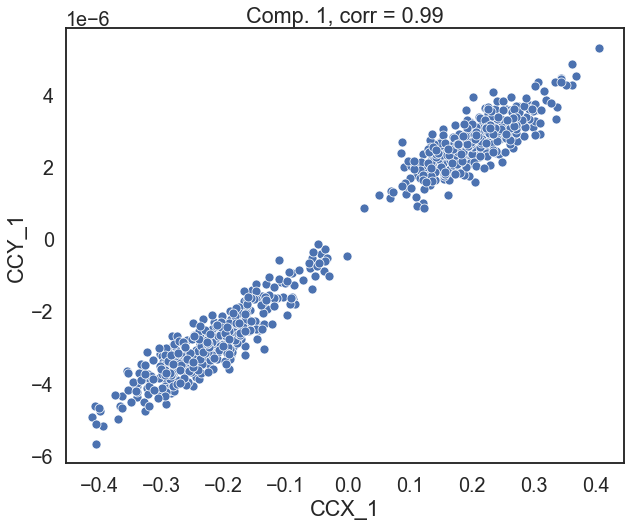

In [35]:
sns.set_context("talk", font_scale=1.2)
plt.figure(figsize=(10,8))
sns.scatterplot(x="CCX_1",
                y="CCY_1", 
                data=cc_res)
plt.title('Comp. 1, corr = %.2f' %
         np.corrcoef(X_c[:, 0], Y_c[:, 0])[0, 1])

<AxesSubplot:xlabel='part_id', ylabel='CCX_1'>

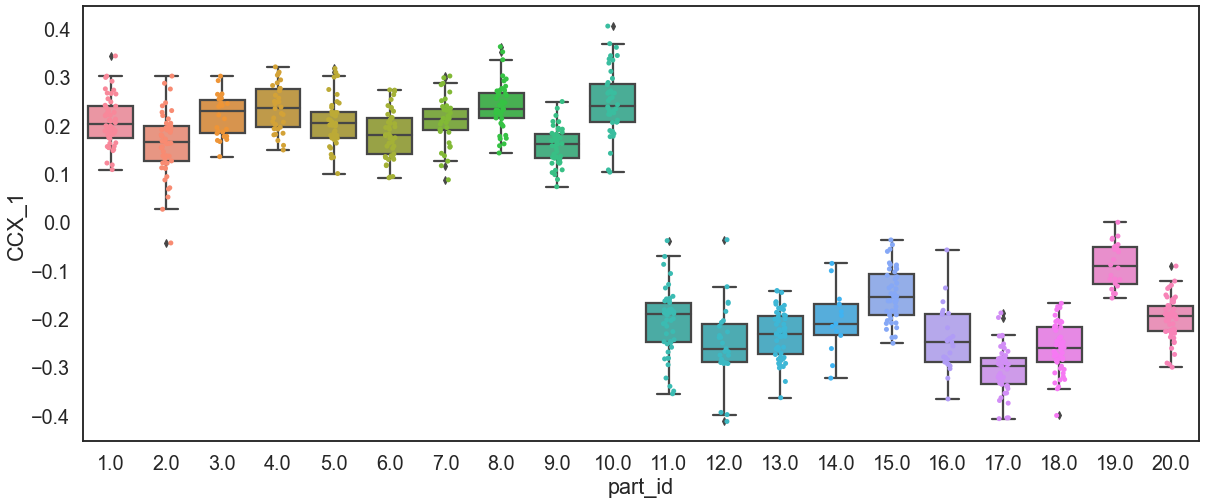

In [36]:
plt.figure(figsize=(20,8))
sns.boxplot(x="part_id",
                y="CCX_1", 
               data=cc_res)
sns.stripplot(x="part_id",
                y="CCX_1", 
                 data=cc_res)

<AxesSubplot:xlabel='part_id', ylabel='CCY_1'>

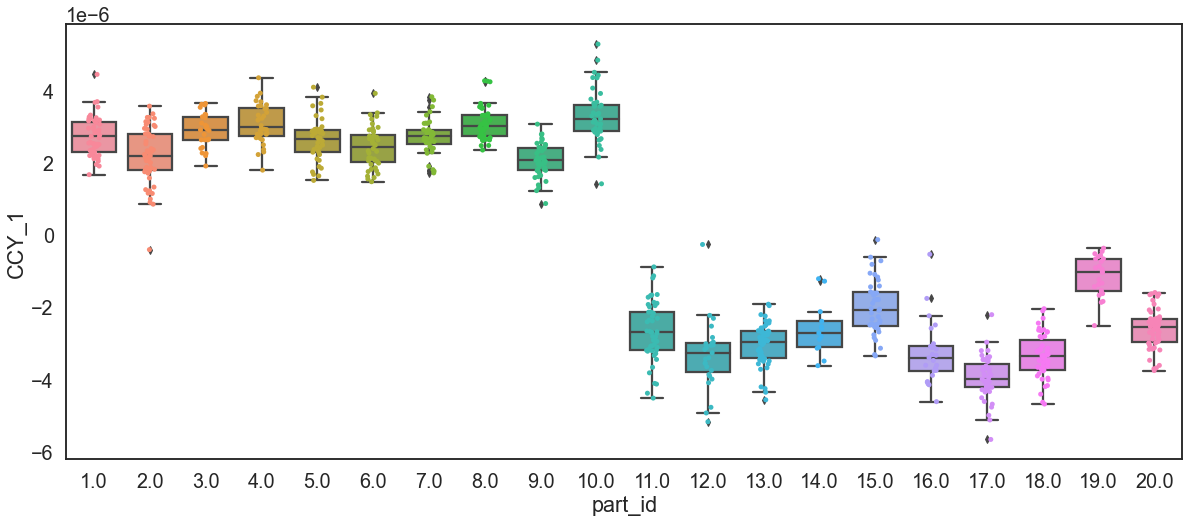

In [37]:
plt.figure(figsize=(20,8))
sns.boxplot(x="part_id",
                y="CCY_1", 
                 data=cc_res)
sns.stripplot(x="part_id",
                y="CCY_1", 
                 data=cc_res)

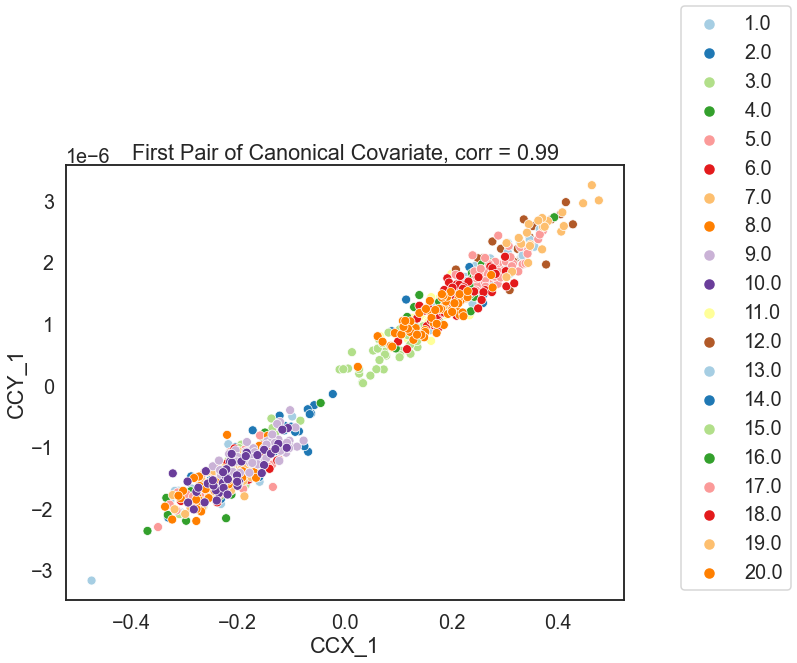

In [15]:
fig, ax = plt.subplots(figsize=(10,8))
sns.scatterplot(x="CCX_1",
                y="CCY_1", 
                hue="part_id", data=cc_res, palette="Paired")
plt.title('First Pair of Canonical Covariate, corr = %.2f' %
         np.corrcoef(X_c[:, 0], Y_c[:, 0])[0, 1])
ax.legend(loc="lower center",bbox_to_anchor=(1.2, 0), ncol=1)

In [16]:
ccX_df = pd.DataFrame({"CCX_1":X_c[:, 0],
                       "CCX_2":X_c[:, 1],
                       "part_id":cc_res.part_id.astype('category').cat.codes})

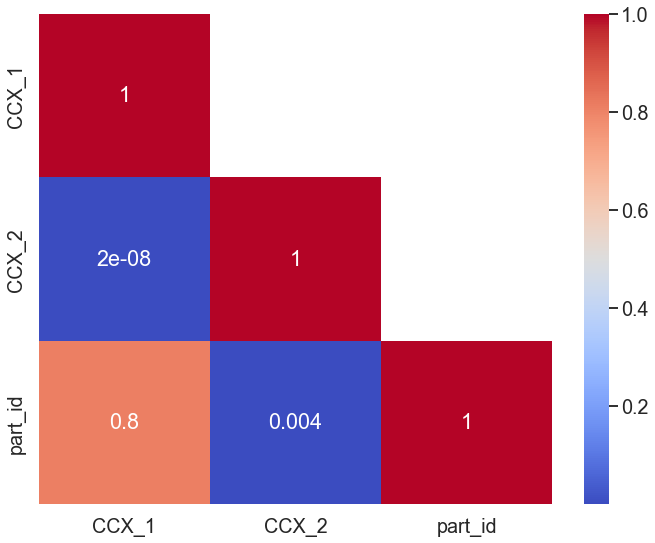

In [17]:
corr_X_df= ccX_df.corr(method='pearson') 
plt.figure(figsize=(10,8))
X_df_lt = corr_X_df.where(np.tril(np.ones(corr_X_df.shape)).astype(np.bool))
sns.heatmap(X_df_lt,cmap="coolwarm",annot=True,fmt='.1g')
plt.tight_layout()

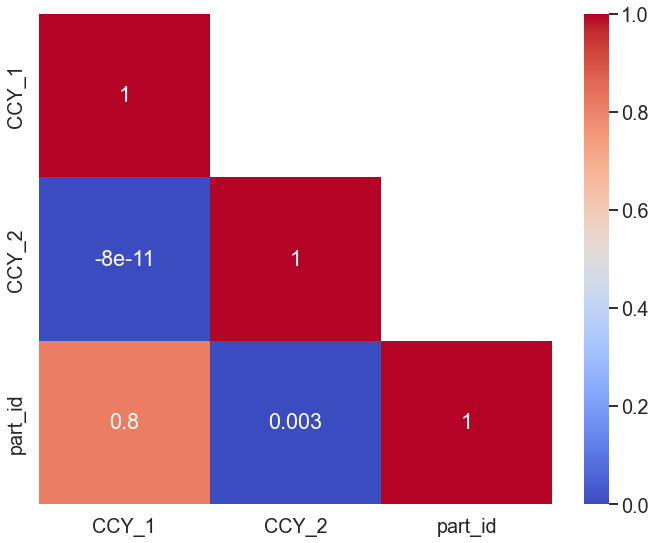

In [18]:
# second pair of canonical covariates with the dataset 
ccY_df = pd.DataFrame({"CCY_1":Y_c[:, 0],
                       "CCY_2":Y_c[:, 1],
                       "part_id":cc_res.part_id.astype('category').cat.codes
                      })
 
# compute correlation with Pandas corr()
corr_Y_df= ccY_df.corr(method='pearson') 
 
# Get lower triangular correlation matrix
Y_df_lt = corr_Y_df.where(np.tril(np.ones(corr_Y_df.shape)).astype(np.bool))
 
# make a lower triangular correlation heatmap with Seaborn
plt.figure(figsize=(10,8))
sns.heatmap(Y_df_lt,cmap="coolwarm",annot=True,fmt='.1g')
plt.tight_layout()

In [41]:
xrot = ca.x_rotations_
yrot = ca.y_rotations_

In [14]:
# Put them together in a numpy matrix
xyrot = np.vstack((xrot,yrot))

nvariables = xyrot.shape[0]

plt.figure(figsize=(15, 15))
plt.xlim((-1,1))
plt.ylim((-1,1))

# Plot an arrow and a text label for each variable
for var_i in range(nvariables):
  x = xyrot[var_i,0]
  y = xyrot[var_i,1]

  plt.arrow(0,0,x,y)
  plt.scatter(x,y, color='red' if var_i >= 6 else 'blue')

plt.show()

NameError: name 'xrot' is not defined

In [29]:
from sklearn.cross_decomposition import CCA

X = gemap.drop(columns='part_id')
Y = emb_down.drop(columns='part_id')


cca = CCA(n_components=3)
cca.fit(X, Y)
#X_c, Y_c = cca.transform(X, Y)

ValueError: Found input variables with inconsistent numbers of samples: [1096, 966]

In [1]:
gcol = np.core.defchararray.add(np.arange(X.shape[1]).astype('str'),['g']*X.shape[1])
pycol = np.core.defchararray.add(np.arange(Y.shape[1]).astype('str'),['py']*Y.shape[1])

lab = np.hstack((gcol, pycol))

NameError: name 'np' is not defined

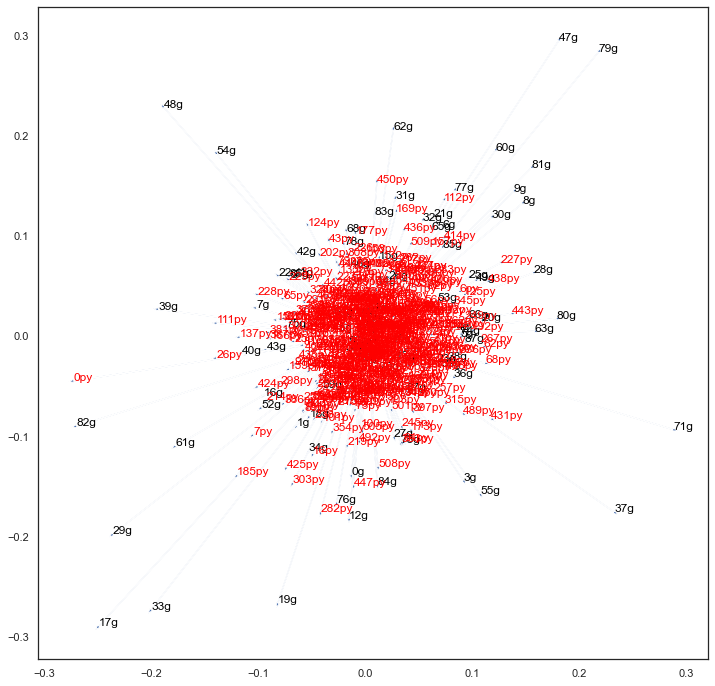

In [37]:
# Obtain the rotation matrices
xrot = cca.x_rotations_
yrot = cca.y_rotations_

# Put them together in a numpy matrix
xyrot = np.vstack((xrot,yrot))

nvariables = xyrot.shape[0]

plt.figure(figsize=(12, 12))
#plt.xlim((-0.2,0.2))
#plt.ylim((-0.2,0.2))

# Plot an arrow and a text label for each variable
for var_i in range(nvariables):
  x = xyrot[var_i,0]
  y = xyrot[var_i,1]

  plt.arrow(0,0,x,y)
  plt.text(x,y,lab[var_i], color='red' if 'py' in lab[var_i] else 'black')

plt.show()

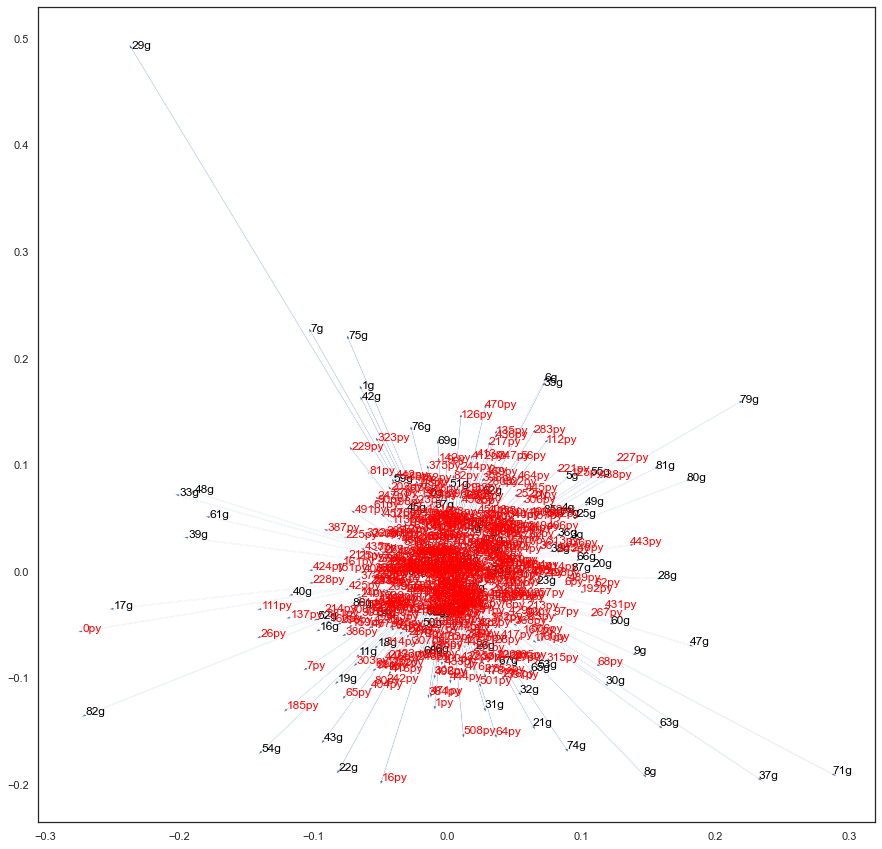

In [35]:
# Obtain the rotation matrices
xrot = cca.x_rotations_
yrot = cca.y_rotations_

# Put them together in a numpy matrix
xyrot = np.vstack((xrot,yrot))

nvariables = xyrot.shape[0]

plt.figure(figsize=(15, 15))
#plt.xlim((-0.2,0.2))
#plt.ylim((-0.2,0.2))

# Plot an arrow and a text label for each variable
for var_i in range(nvariables):
  x = xyrot[var_i,0]
  y = xyrot[var_i,2]

  plt.arrow(0,0,x,y)
  plt.text(x,y,lab[var_i], color='red' if 'py' in lab[var_i] else 'black')

plt.show()

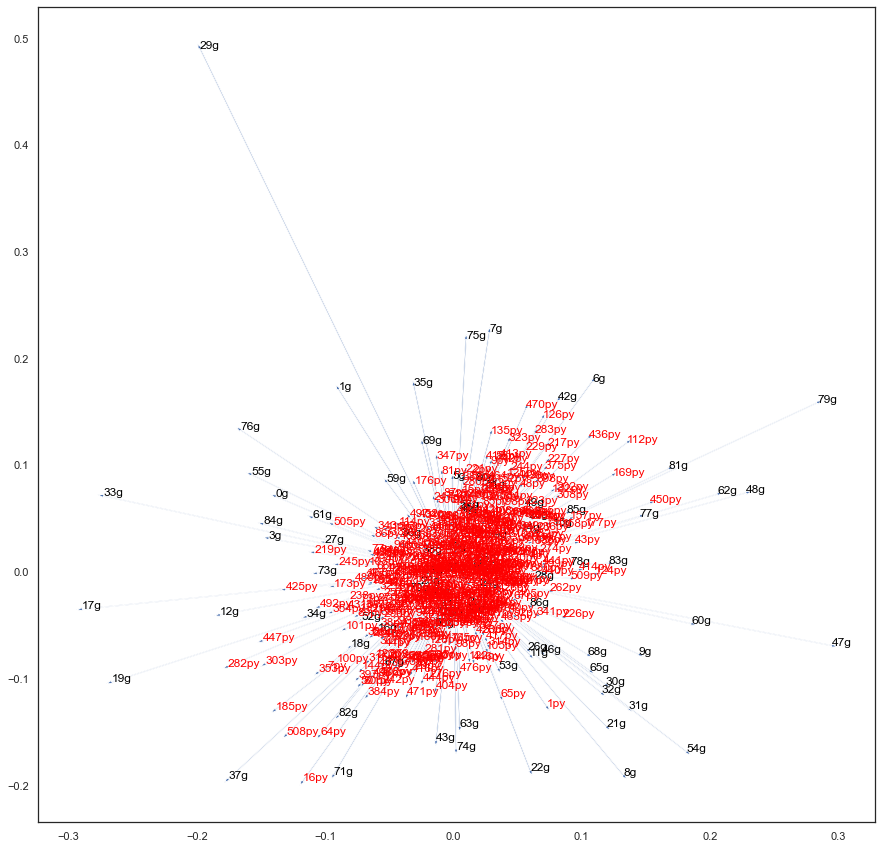

In [34]:
# Obtain the rotation matrices
xrot = cca.x_rotations_
yrot = cca.y_rotations_

# Put them together in a numpy matrix
xyrot = np.vstack((xrot,yrot))

nvariables = xyrot.shape[0]

plt.figure(figsize=(15, 15))
#plt.xlim((-0.2,0.2))
#plt.ylim((-0.2,0.2))

# Plot an arrow and a text label for each variable
for var_i in range(nvariables):
  x = xyrot[var_i,1]
  y = xyrot[var_i,2]

  plt.arrow(0,0,x,y)
  plt.text(x,y,lab[var_i], color='red' if 'py' in lab[var_i] else 'black')

plt.show()

In [55]:
#gemap.drop(columns=['start','end'])
#sns.scatterplot(x=X_c[:,1], y=Y_c[:,1])
Y_c.shape
np.corrcoef(X_c[:,1], Y_c[:,1])

array([[1., 1.],
       [1., 1.]])

In [13]:
gemap

,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope,F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope,...,slopeUV500-1500_sma3nz_amean,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp,part_id
file,,,,,,,,,,,,,,,,,,,,,
/Users/rahulbrito/Documents/projects/infantvoice/data/Full_Readings/16khz_020422_postpartum_moms/014.wav,34.656258,0.226665,29.325533,32.339630,37.971905,8.646372,417.31317,756.03970,176.34970,421.68176,...,0.025749,0.027282,1.884727,1.676721,0.197657,0.175015,0.396689,1.097285,-29.941727,014
/Users/rahulbrito/Documents/projects/infantvoice/data/Full_Readings/16khz_020422_postpartum_moms/001.wav,40.614002,0.193990,33.898705,38.412937,48.591347,14.692642,259.02628,344.97830,189.37656,349.84848,...,0.015704,0.041610,2.023577,2.042703,0.268282,0.310515,0.240248,0.514109,-27.318361,001
/Users/rahulbrito/Documents/projects/infantvoice/data/Full_Readings/16khz_020422_postpartum_moms/015.wav,40.012825,0.161124,34.837110,39.588940,45.550262,10.713154,231.97970,359.49014,140.45279,287.63593,...,0.007072,0.080939,2.109048,1.968953,0.266091,0.315487,0.251745,1.239365,-26.354046,015
/Users/rahulbrito/Documents/projects/infantvoice/data/Full_Readings/16khz_020422_postpartum_moms/003.wav,38.130420,0.165808,32.843327,36.665283,42.954690,10.111362,212.71884,369.81903,187.45552,309.13373,...,0.012537,0.087544,1.871052,2.005616,0.209840,0.224457,0.282699,0.540035,-21.986076,003
/Users/rahulbrito/Documents/projects/infantvoice/data/Full_Readings/16khz_020422_postpartum_moms/017.wav,34.798317,0.137045,32.089806,34.590267,37.231243,5.141438,156.26746,403.00116,100.74687,201.76405,...,0.016761,0.035364,1.985528,1.621728,0.284073,0.266139,0.330600,0.742869,-26.701868,017
/Users/rahulbrito/Documents/projects/infantvoice/data/Full_Readings/16khz_020422_postpartum_moms/016.wav,36.757298,0.207710,30.193680,35.667973,42.064240,11.870560,241.57968,521.67070,161.91745,300.65695,...,0.018943,0.033887,2.033679,1.692516,0.237146,0.236825,0.363136,1.277003,-25.765015,016
/Users/rahulbrito/Documents/projects/infantvoice/data/Full_Readings/16khz_020422_postpartum_moms/002.wav,41.346184,0.193928,33.896748,40.291460,48.581110,14.684361,242.58864,363.40833,193.45422,334.92056,...,0.010263,0.047721,1.986158,1.840942,0.177130,0.202996,0.307970,0.498998,-29.922302,002
/Users/rahulbrito/Documents/projects/infantvoice/data/Full_Readings/16khz_020422_postpartum_moms/006.wav,39.151253,0.200883,33.308697,36.586136,45.129265,11.820568,292.00543,477.85782,190.17604,320.52896,...,0.019526,0.041911,2.212083,2.067429,0.194195,0.175429,0.291202,0.530252,-29.348478,006
/Users/rahulbrito/Documents/projects/infantvoice/data/Full_Readings/16khz_020422_postpartum_moms/012.wav,37.890427,0.199913,32.722797,36.460660,42.930946,10.208149,339.92280,572.84937,182.87581,330.69920,...,0.020148,0.049410,2.060640,1.660605,0.183360,0.204085,0.377940,1.063458,-25.793747,012


In [115]:
emb_down

,0,1,2,3,4,5,...,507,508,509,510,511,part_id
0,-0.004395,0.002940,0.006051,0.005982,-0.016935,-0.004579,...,0.012641,-0.003614,0.004561,0.019628,0.010845,1.0
1,-0.000478,0.013278,-0.002441,-0.001681,0.001405,0.007172,...,-0.000975,-0.008498,0.028066,0.000678,0.015895,1.0
2,0.006058,0.015329,-0.002296,-0.015331,-0.018842,-0.007585,...,0.020342,-0.013018,0.011131,-0.004131,-0.002359,1.0
3,0.005696,0.031043,0.002463,0.003892,0.003265,0.035642,...,0.003426,0.006590,0.012869,0.025278,0.031090,1.0
4,-0.006802,0.015669,-0.010422,-0.016533,-0.005459,0.017177,...,0.005121,-0.000465,-0.000365,-0.015865,0.006604,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6164,0.000454,0.004453,0.000439,-0.016461,-0.010892,0.012864,...,-0.014279,-0.002140,-0.002534,-0.018381,0.011236,20.0
6165,0.004410,-0.014337,0.000491,0.008956,-0.006893,0.000222,...,-0.040579,-0.022276,-0.009942,-0.011315,-0.022789,20.0
6166,-0.003744,-0.011442,0.015911,0.001470,-0.009805,0.018522,...,-0.019479,-0.011869,0.009121,0.002006,0.009102,20.0
6167,-0.007645,0.001253,-0.022638,-0.000676,-0.015432,0.012576,...,-0.022812,-0.013946,0.032045,0.005491,0.016577,20.0


In [114]:
pd.options.display.max_columns=12